In [1]:
import os
import glob
import matplotlib.pyplot as plt
import datetime as dt

import arcticdb as adb
import pandas as pd

In [2]:
arctic = adb.Arctic("lmdb://equity_options")
lib = arctic.get_library("options", create_if_missing=True)

In [3]:
def read_chains(fl):
    df = (
        pd
        .read_csv(fl)
        .set_index("date")
    )
    df.index = pd.to_datetime(df.index)
    return df

In [6]:
parent_dir = os.path.dirname(os.getcwd())
files = glob.glob(os.path.join(parent_dir,"data","rut-eod", "*.csv"))
# files

In [7]:
# files = glob.glob(os.path.join("rut-eod", "*.csv"))
for fl in files:
    chains = read_chains(fl)
    chains.option_expiration = pd.to_datetime(chains.option_expiration)
    underlyings = chains.symbol.unique()
    for underlying in underlyings:
        df = chains[chains.symbol == underlying]
        adb_sym = f"options/{underlying}"
        adb_fcn = lib.update if lib.has_symbol(adb_sym) else lib.write
        adb_fcn(adb_sym, df)

In [8]:
def read_vol_curve(as_of_date, underlying, expiry, delta_low, delta_high):
    q = adb.QueryBuilder()
    filter = (
        (q["option_expiration"] == expiry) & 
        (
            (
                (q["delta"] >= delta_low) & (q["delta"] <= delta_high)
            ) | (
                (q["delta"] >= -delta_high) & (q["delta"] <= -delta_low)
            )
        )
    )
    q = (
        q[filter]
        .groupby("strike")
        .agg({"iv": "mean"})
    )
    return lib.read(
        f"options/{underlying}", 
        date_range=(as_of_date, as_of_date),
        query_builder=q
    ).data

In [9]:

def query_expirations(as_of_date, underlying, dte=30):
    q = adb.QueryBuilder()
    filter = (q.option_expiration > as_of_date + dt.timedelta(days=dte))
    q = q[filter].groupby("option_expiration").agg({"volume": "sum"})
    return (
        lib
        .read(
            f"options/{underlying}", 
            date_range=(as_of_date, as_of_date), 
            query_builder=q
        )
        .data
        .sort_index()
        .index
    )

In [10]:

as_of_date = pd.Timestamp("2013-06-03")
expiry = pd.Timestamp("2013-06-22")
underlying = "RUT"
dte = 30
delta_low = 0.05
delta_high = 0.50

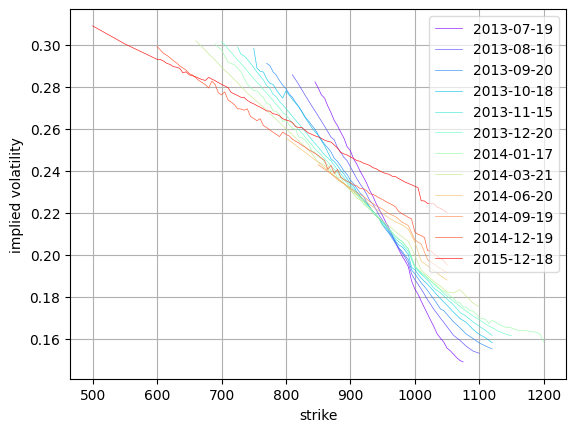

In [11]:
expiries = query_expirations(as_of_date, underlying, dte)
_, ax = plt.subplots(1, 1)
cmap = plt.get_cmap("rainbow", len(expiries))
format_kw = {"linewidth": 0.5, "alpha": 0.85}
for i, expiry in enumerate(expiries):
    curve = read_vol_curve(
        as_of_date, 
        underlying, 
        expiry, 
        delta_low, 
        delta_high
    )
    (
        curve
        .sort_index()
        .plot(
            ax=ax, 
            y="iv", 
            label=expiry.strftime("%Y-%m-%d"),
            grid=True,
            color=cmap(i),
            **format_kw
        )
    )
ax.set_ylabel("implied volatility")
ax.legend(loc="upper right", framealpha=0.7)